# Part 1 - GradCAM - Sunglass Finder

## Loading the Library and VGG16 Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
model = VGG16(weights="imagenet")
model.summary()

Using TensorFlow backend.
W0916 21:54:12.893035 140139884951360 deprecation_wrapper.py:119] From /home/sambit/anaconda3/envs/opencv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 21:54:12.903990 140139884951360 deprecation_wrapper.py:119] From /home/sambit/anaconda3/envs/opencv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 21:54:12.906063 140139884951360 deprecation_wrapper.py:119] From /home/sambit/anaconda3/envs/opencv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 21:54:12.924251 140139884951360 deprecation_wrapper.py:119] From /home/sambit/anaconda3/envs/opencv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name t

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Loading the Image

1. The image is loaded from a local file. 
2. Image is resized to $224\times224$ with cubic interpolation
3. Image is preprocessed and normalized
4. Image is evaluated against the model to predict a class. 
5. Class 837 - sunglasses, dark glasses, shades was predicted
6. Class 836 - sunglasses will be applied for GradCAM activation and selected

The activation is shown for convolution block 5 for all 3 convolutions. 

Predicted class: 837 Expected Class: 836


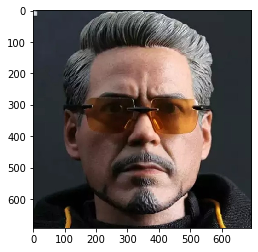

In [2]:
goggles = cv2.imread("goggles.jpg")
goggles = cv2.cvtColor(goggles, cv2.COLOR_BGR2RGB)
plt.imshow(goggles)

goggles = cv2.resize(goggles, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(goggles)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
class_idx = np.argmax(preds[0])

SUNGLASSES_LABEL = 836
print("Predicted class: %d Expected Class: %d" %(class_idx, SUNGLASSES_LABEL))

class_output = model.output[:, SUNGLASSES_LABEL]

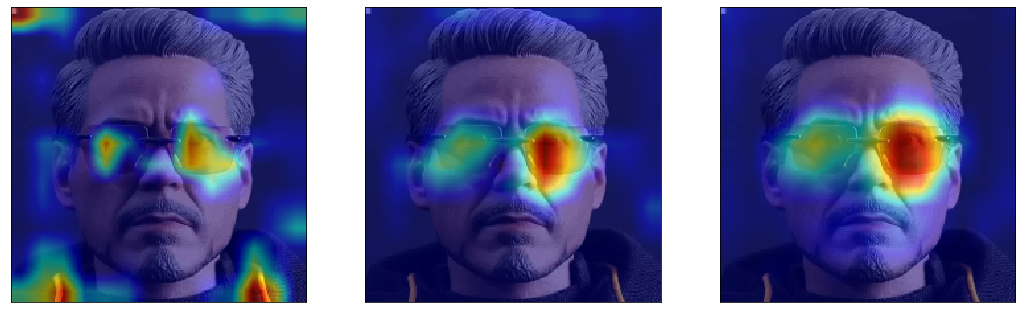

In [3]:
from keras import backend as K

fig = plt.figure(figsize=(18,6))
ifig = 1

for layer_name in ["block5_conv1", "block5_conv2", "block5_conv3"]: 
    last_conv_layer = model.get_layer(layer_name)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (goggles.shape[1], goggles.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(goggles, 0.5, heatmap, 0.5, 0)
    ax = fig.add_subplot(1, 3, ifig, xticks=[], yticks=[])
    ifig += 1
    plt.imshow(superimposed_img)
plt.show()    

# Part - 2 - Receptive Field

The paper *CNN based medical image segmentation* provides a framework for visualization of CNN output applying deconvolution. However, the convolution operations carried out as part of the deconvolution smoothing step also affects the receptive field. Deconvolution can be considered a two step operation. 

1. Repeating a lesser resolution value multiple times
2. Convolution operation to smoothen the data

With padding carried out such that image remains the same size, the change in receptive field is affected only by number of upsampled or downsampling carried out. And such a change in receptive field can be mentioned as the equation as described in the paper, reproduced here:


$$ \psi_{n} = \psi_{n-1} + 2^{(\eta - \tau)}(FilterSize - 1) $$
$$ \psi_{0} = 1 $$

where, $\eta$ is number of subsampling (strided) carried out and $\tau$ is number of upsampling carried out so far. At step 7, 3 subsampling operations are carried out, hence the total increase of the receptive field is:
$2^{3} (3 - 1) = 16$. Hence, the change from 29 to 45.

The same has been also discussed by the author in the issue discussion: https://github.com/BRML/CNNbasedMedicalSegmentation/issues/2

# Appendix - Complete Activation 

The complete activation map for the Sunglasses image is shown using Keract.

W0916 21:54:16.871659 140139884951360 deprecation_wrapper.py:119] From /home/sambit/anaconda3/envs/opencv/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



input_1:0 (224, 224, 3) -> Skipped. First dimension is not 1.
block1_conv1/Relu:0 (1, 224, 224, 64) 


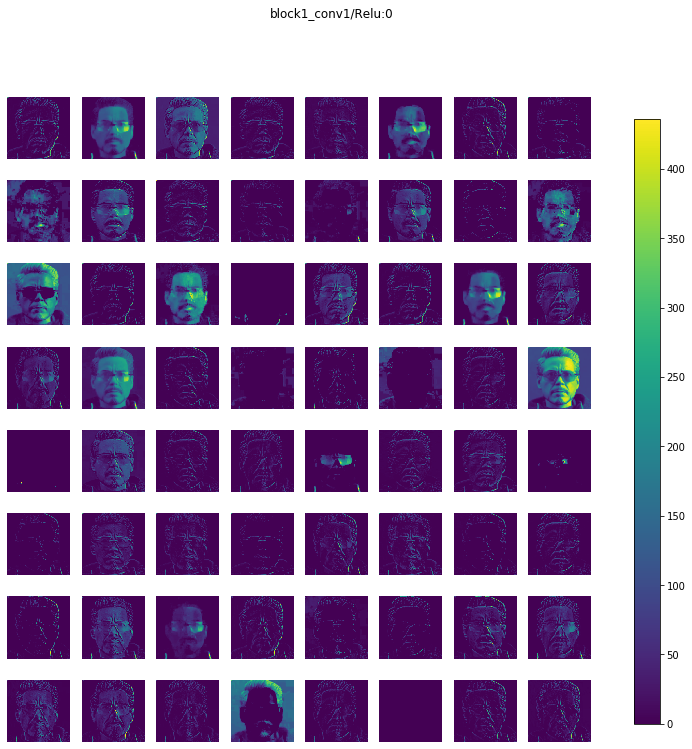

block1_conv2/Relu:0 (1, 224, 224, 64) 


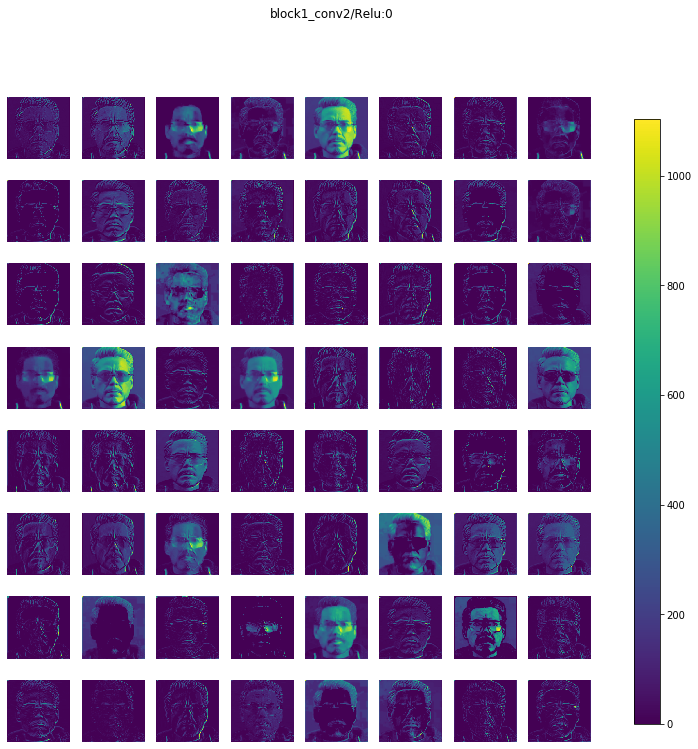

block1_pool/MaxPool:0 (1, 112, 112, 64) 


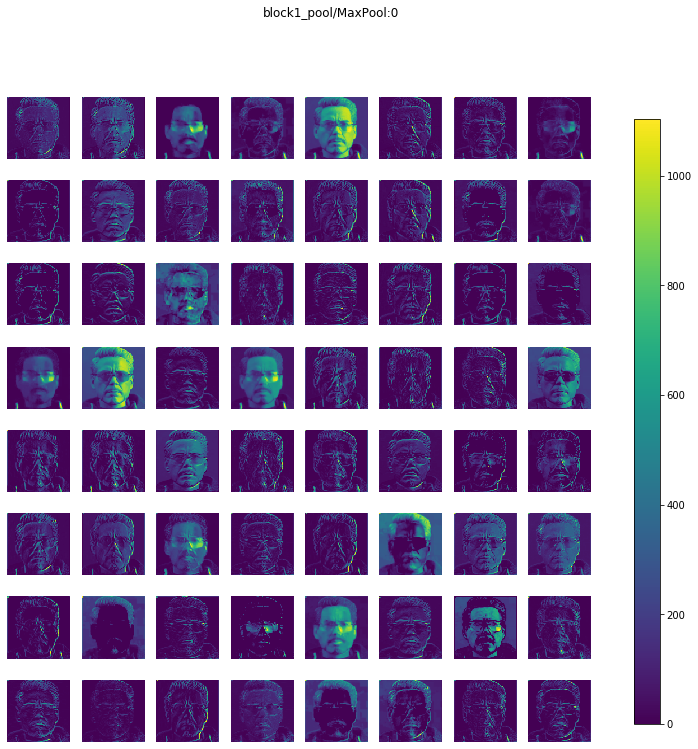

block2_conv1/Relu:0 (1, 112, 112, 128) 


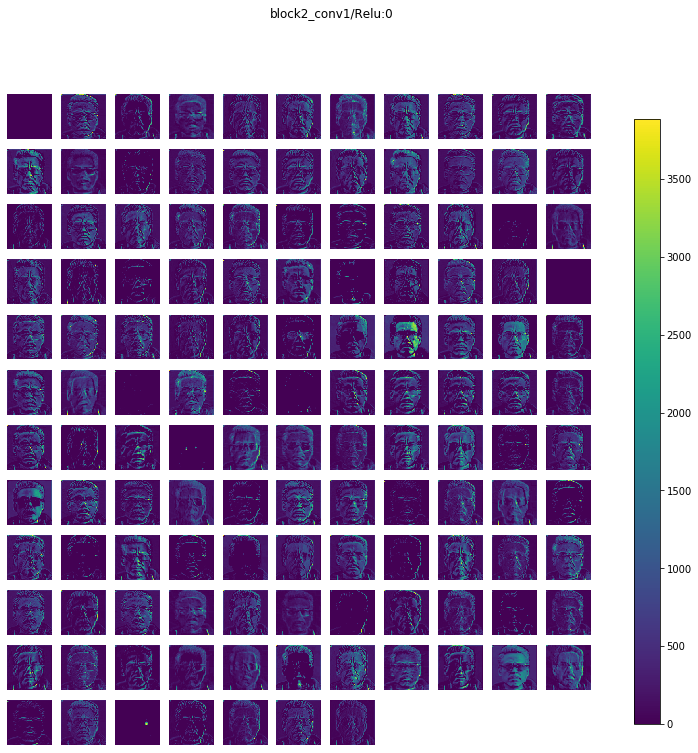

block2_conv2/Relu:0 (1, 112, 112, 128) 


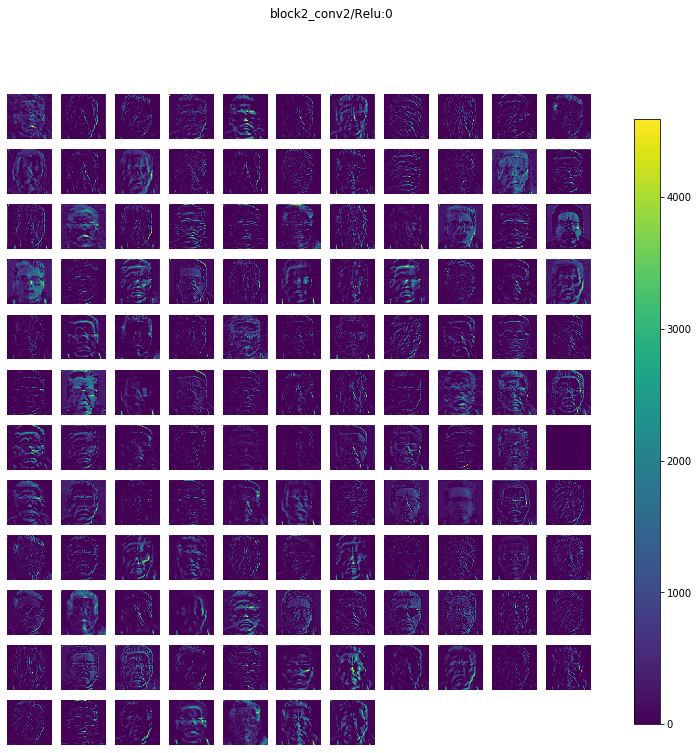

block2_pool/MaxPool:0 (1, 56, 56, 128) 


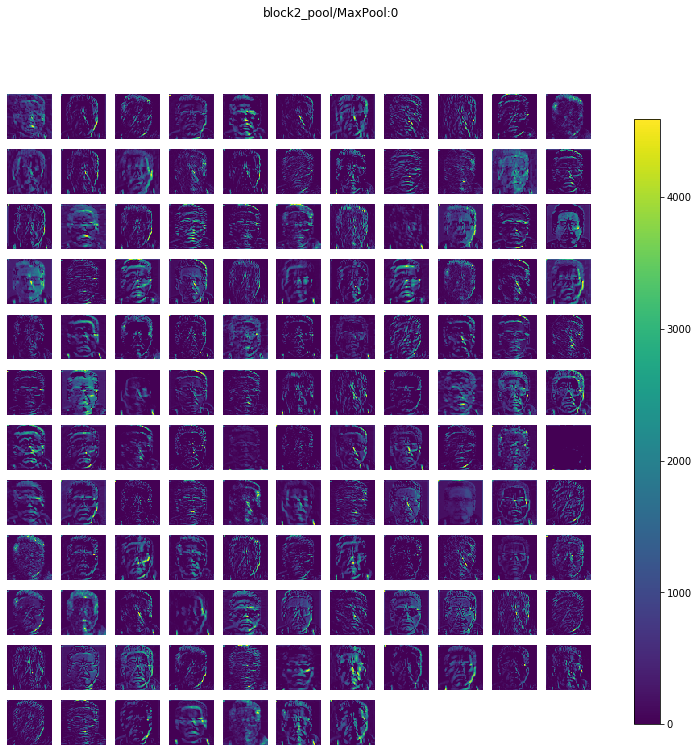

block3_conv1/Relu:0 (1, 56, 56, 256) 


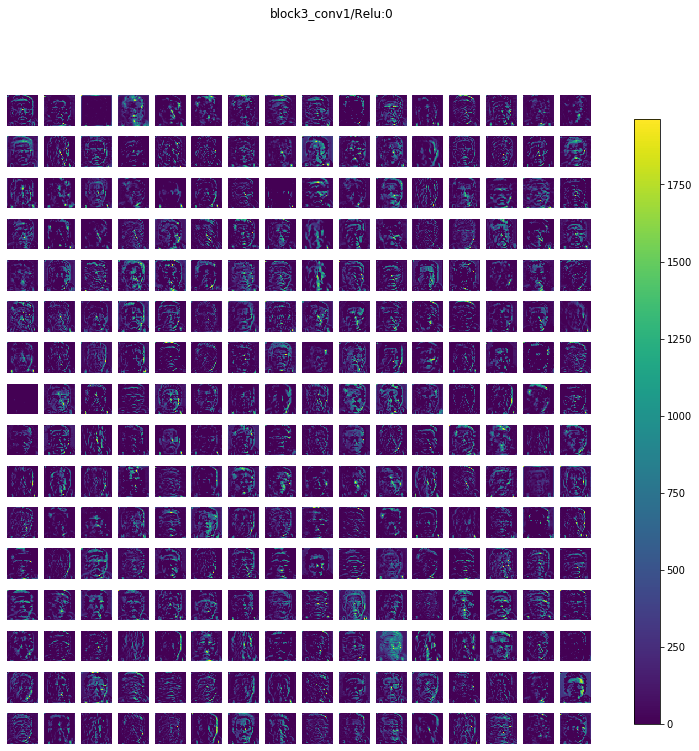

block3_conv2/Relu:0 (1, 56, 56, 256) 


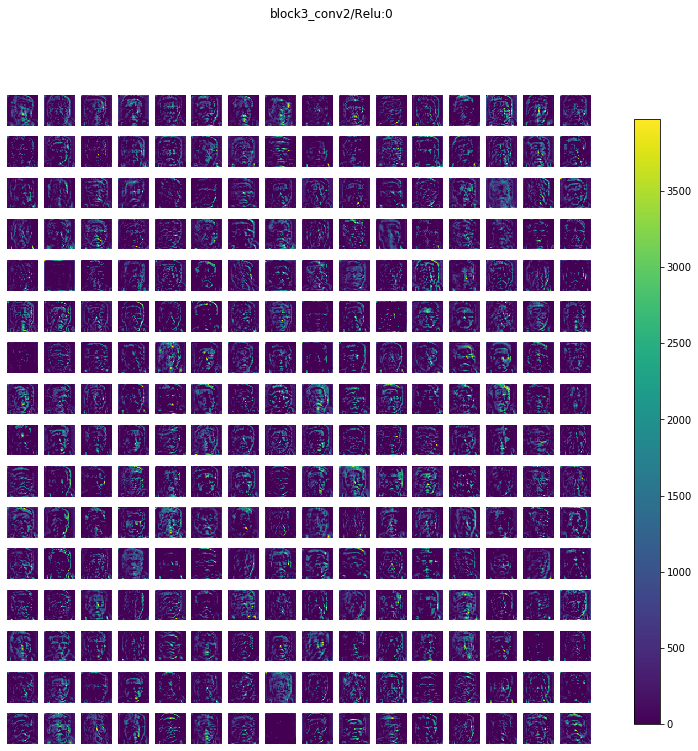

block3_conv3/Relu:0 (1, 56, 56, 256) 


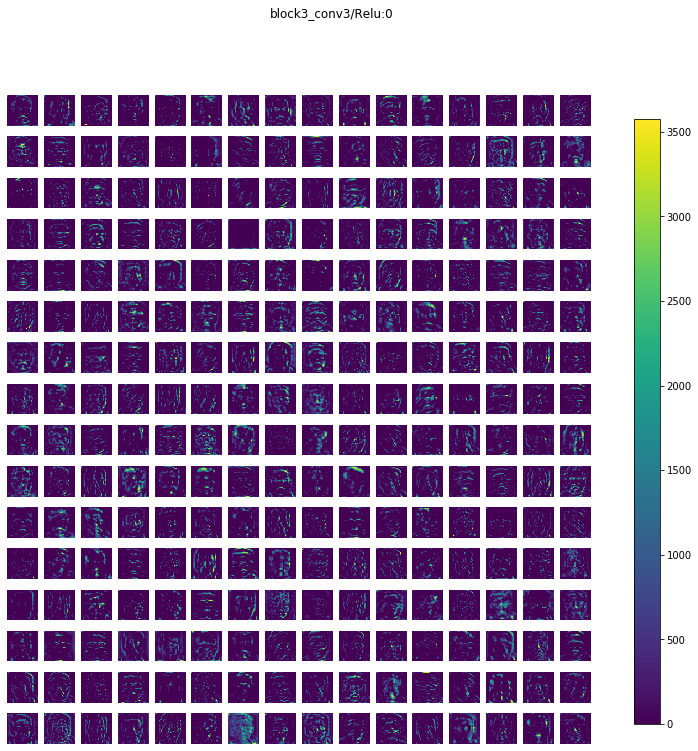

block3_pool/MaxPool:0 (1, 28, 28, 256) 


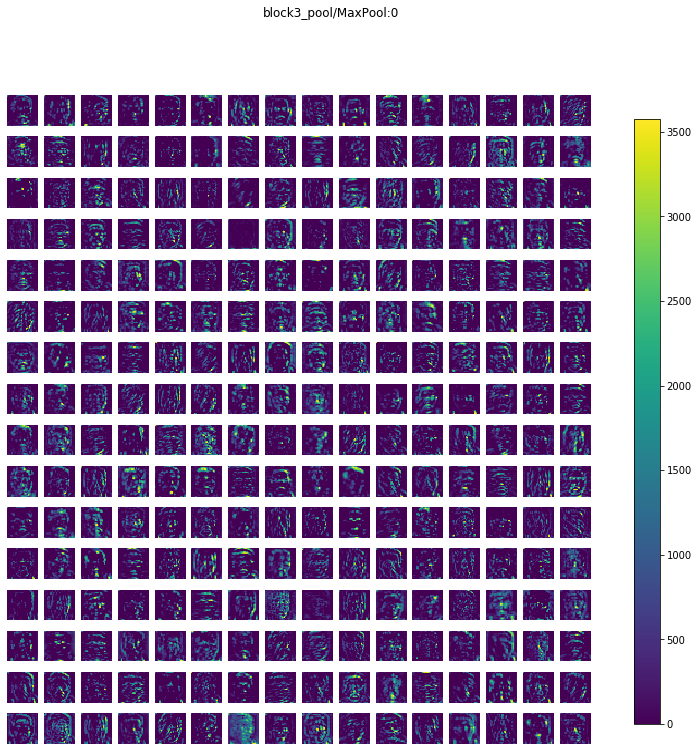

block4_conv1/Relu:0 (1, 28, 28, 512) 


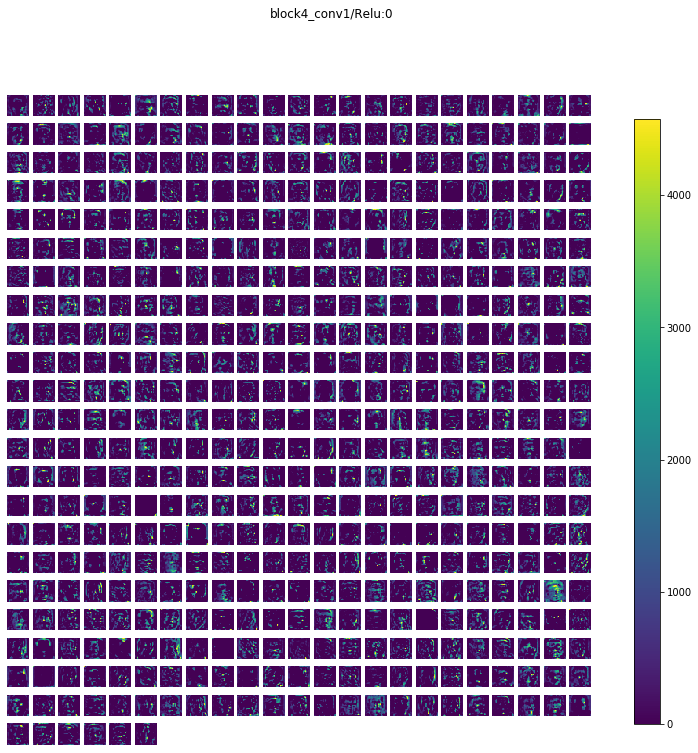

block4_conv2/Relu:0 (1, 28, 28, 512) 


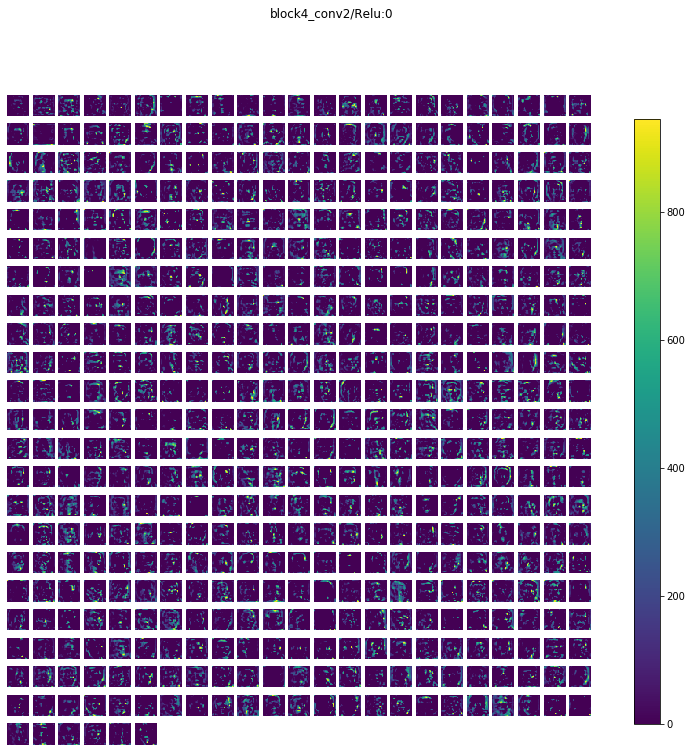

block4_conv3/Relu:0 (1, 28, 28, 512) 


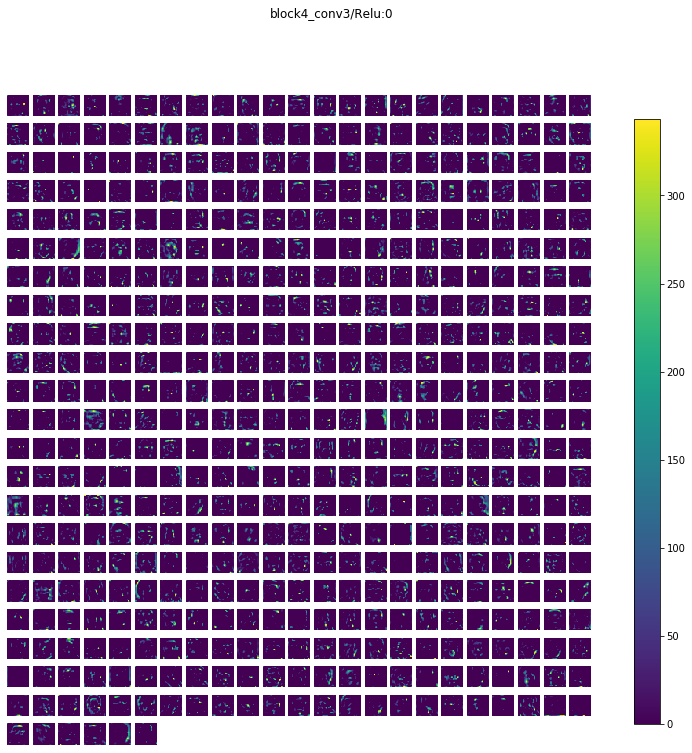

block4_pool/MaxPool:0 (1, 14, 14, 512) 


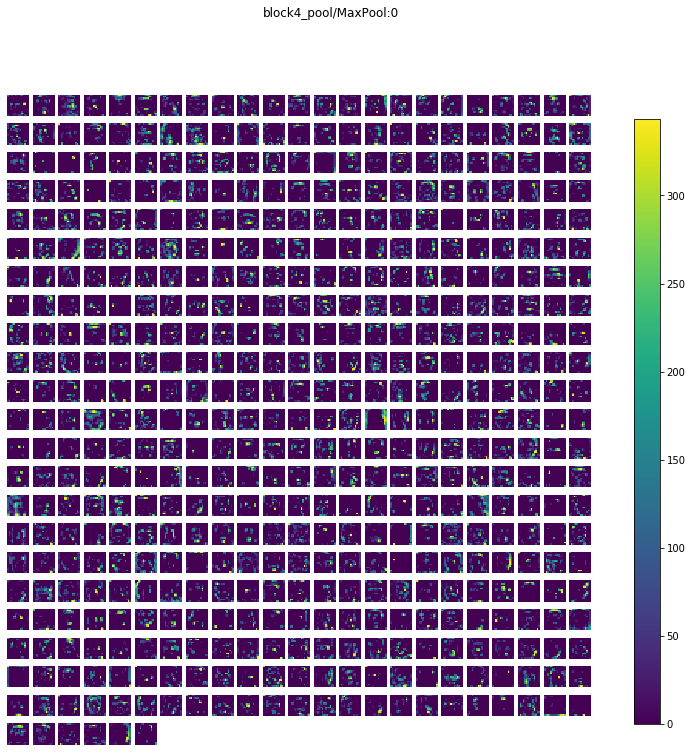

block5_conv1/Relu:0 (1, 14, 14, 512) 


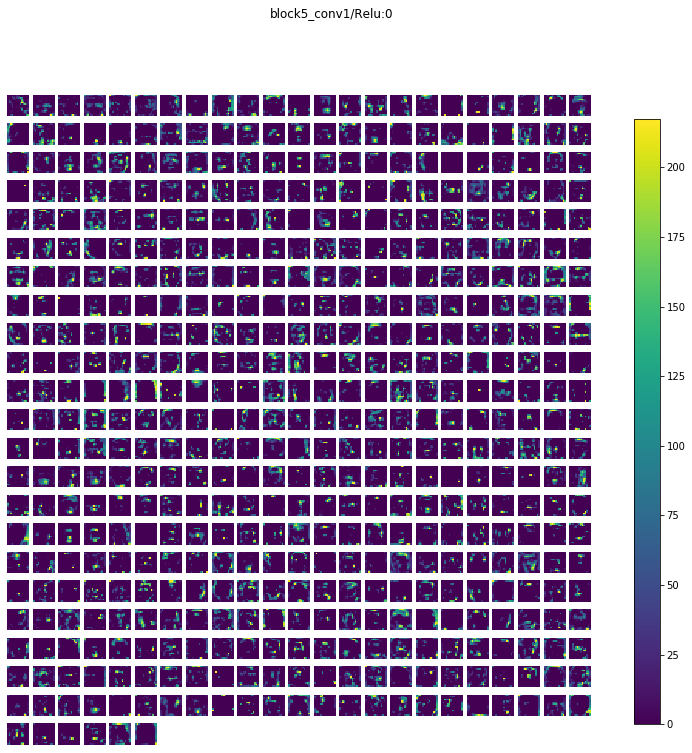

block5_conv2/Relu:0 (1, 14, 14, 512) 


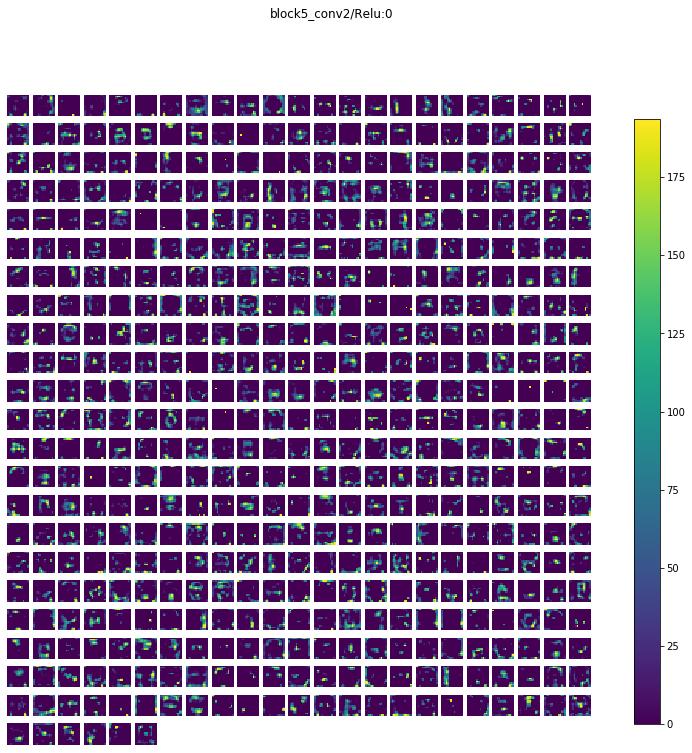

block5_conv3/Relu:0 (1, 14, 14, 512) 


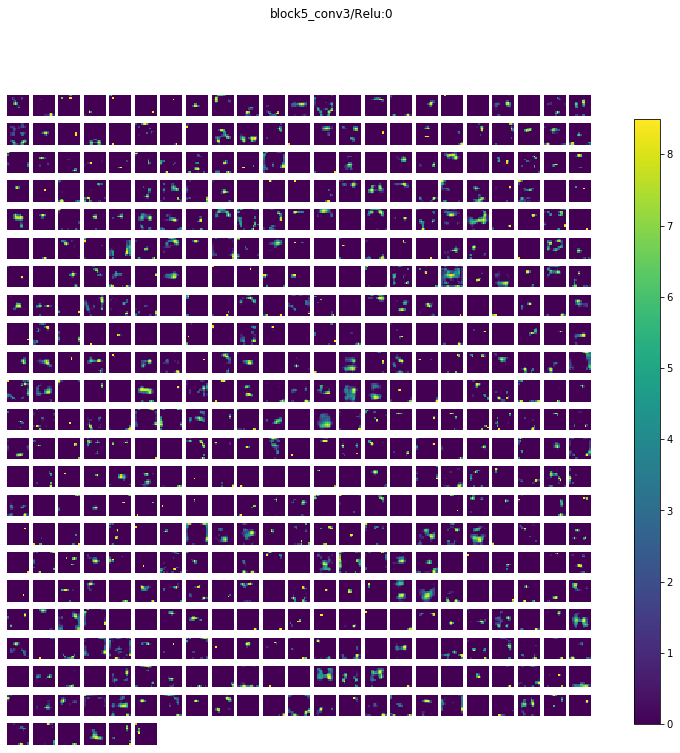

block5_pool/MaxPool:0 (1, 7, 7, 512) 


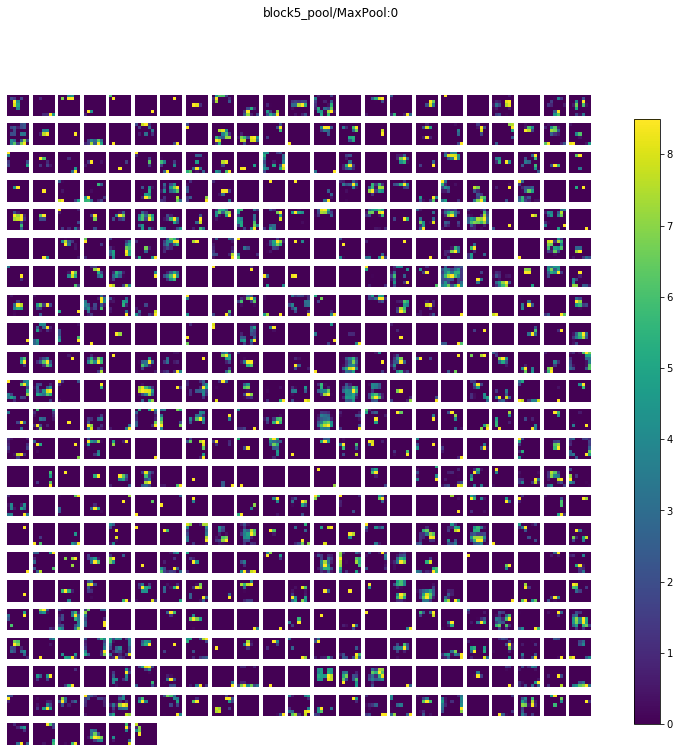

flatten/Reshape:0 (1, 25088) -> Skipped. 2D Activations.
fc1/Relu:0 (1, 4096) -> Skipped. 2D Activations.
fc2/Relu:0 (1, 4096) -> Skipped. 2D Activations.
predictions/Softmax:0 (1, 1000) -> Skipped. 2D Activations.


In [4]:
import keract

image = np.reshape(goggles, (1, goggles.shape[0], goggles.shape[1], goggles.shape[2]))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
activations = keract.get_activations(model, image)
first = activations.get('block1_conv1/Relu:0')
keract.display_activations(activations)